In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from glob import glob
from math import ceil
from skimage import feature
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import jaccard_score

from coring_detector import CoringDetector
from utils import plot_images


## Trainig data

### Images

In [2]:
N_images = 50000

In [3]:
imgs_dir = '../data/train/image/*'
imgs_paths = glob(imgs_dir)
imgs_paths = sorted(imgs_paths)
imgs_paths = imgs_paths[:N_images]

train_dataset = [ cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in imgs_paths]

# Padding images to 256x256

# Find the maximum shape among all arrays
max_shape = max(arr.shape for arr in train_dataset)

# Pad or resize each array to the maximum shape
padded_arrays = [np.pad(arr, [(0, max_shape[0] - arr.shape[0]), (0, max_shape[1] - arr.shape[1])], mode='constant', constant_values=int(np.mean(arr))) for arr in train_dataset]

# Convert the list of arrays to a single NumPy array
train_dataset = np.array(padded_arrays)

# Check the shape of the resulting array
print(train_dataset.shape)

(1438, 256, 256)


### Masks

In [4]:
masks_dir = '../data/train/mask/*'
masks_paths = glob(masks_dir)
masks_paths = sorted(masks_paths)
masks_paths = masks_paths[:N_images]

# Create list with all images in gray scale
masks_gray = [ cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in masks_paths]

# Aplicando abertura para remover ruidos horizontais
kernel = np.ones((5, 5), np.uint8)
masks_gray = [cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel) for img in masks_gray]

# Padding masks to 256x256 

# Find the maximum shape among all arrays
max_shape = max(arr.shape for arr in masks_gray)

# Pad or resize each array to the maximum shape
padded_arrays = [np.pad(arr, [(0, max_shape[0] - arr.shape[0]), (0, max_shape[1] - arr.shape[1])], mode='constant') for arr in masks_gray]

# Convert the list of arrays to a single NumPy array
train_masks = np.array(padded_arrays)

# Get the true centroids for the maks
train_masks_contours = CoringDetector.find_contours(train_masks)
train_masks_centroids = CoringDetector.get_centroids(train_masks_contours)

# plot_images(train_masks, masks_contours, masks_centroids)

# Check the shape of the resulting array
print(train_masks.shape)

(1438, 256, 256)


## Test Data

### Images

In [5]:
imgs_dir = '../data/test/image/*'
imgs_paths = glob(imgs_dir)
imgs_paths = sorted(imgs_paths)
imgs_paths = imgs_paths[:N_images]

test_dataset = [ cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) for image_path in imgs_paths]

# Padding images to 256x256

# Find the maximum shape among all arrays
max_shape = max(arr.shape for arr in test_dataset)

# Pad or resize each array to the maximum shape
padded_arrays = [np.pad(arr, [(0, max_shape[0] - arr.shape[0]), (0, max_shape[1] - arr.shape[1])], mode='constant', constant_values=int(np.mean(arr))) for arr in test_dataset]

# Convert the list of arrays to a single NumPy array
test_dataset = np.array(padded_arrays)

# Check the shape of the resulting array
print(test_dataset.shape)

(263, 256, 256)


### Masks

In [6]:
masks_dir = '../data/test/mask/*'
masks_paths = glob(masks_dir)
masks_paths = sorted(masks_paths)
masks_paths = masks_paths[:N_images]

# Create list with all images in gray scale
masks_gray = [ cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) for mask_path in masks_paths]

# Aplicando abertura para remover ruidos horizontais
kernel = np.ones((5, 5), np.uint8)
masks_gray = [cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel) for img in masks_gray]

# Padding masks to 256x256 

# Find the maximum shape among all arrays
max_shape = max(arr.shape for arr in masks_gray)

# Pad or resize each array to the maximum shape
padded_arrays = [np.pad(arr, [(0, max_shape[0] - arr.shape[0]), (0, max_shape[1] - arr.shape[1])], mode='constant') for arr in masks_gray]

# Convert the list of arrays to a single NumPy array
test_masks = np.array(padded_arrays)

# Get the true centroids for the maks
test_masks_contours = CoringDetector.find_contours(test_masks)
test_masks_centroids = CoringDetector.get_centroids(test_masks_contours)

# Check the shape of the resulting array
print(test_masks.shape)

(263, 256, 256)


In [7]:
# plot_images(test_masks)

## Model Otimization

### Create parameters sets

In [8]:
# Define the parameter ranges and steps
min_area_range = np.arange(1, 10, 5.)  # from 10 to 50, steps of 10
max_area_range = np.arange(400, 450, 50)  # from 250 to 450, steps of 50
min_round_ratio_range = np.arange(0.1, 0.2, 0.1)  # from 0.25 to 0.75, steps of 0.125
max_round_ratio_range = np.arange(0.5, 1.5, 0.5)  # from 1.0 to 3.0, steps of 0.5

canny_sigma_range = np.arange(1, 5, 0.5)
N1_range = np.arange(11, 32, step=2)
N2_fixed = [9]
N3_fixed = [5]

# Construct the param_grid
param_grid =  {
    "min_area": min_area_range,
    "max_area": max_area_range,
    "min_round_ratio": min_round_ratio_range,
    "max_round_ratio": max_round_ratio_range,
    "canny_sigma": canny_sigma_range,
    "N1": N1_range,
    "N2": N2_fixed,
    "N3": N3_fixed,
}

print(f"A total of {len(param_grid)} parameters set were created.")


A total of 8 parameters set were created.


In [9]:
# clf = GridSearchCV(CoringDetector(), param_grid=param_grid, verbose=1, n_jobs=1)
# clf.fit(train_dataset, masks_centroids)

In [10]:
# clf.best_score_

In [11]:
# clf.best_params_

Os melhores parametros encontrados foram: 

    Parâmetros das tranformações: N1=23, canny_sigma=2.6

    Parâmetros de filtragem: min_area=0.5, max_area=400, min_round_ratio=0.5, max_round_ratio=1.0

## Otimization Results

### Results on the trainig dataset

In [12]:
train_detecor = CoringDetector(metric="f1_score", N1=23, N2=7, N3=5, canny_sigma=2.6, max_area=400, max_round_ratio=1.0, min_area=0.5, min_round_ratio=0.5)
train_predictions = train_detecor.fit_transform(train_dataset)
train_detecor.score(train_dataset, train_masks_centroids)

print("TP", train_detecor.true_positives_rate)
print("FP", train_detecor.false_positives_rate)
print("FN", train_detecor.false_negatives_rate)
print("Recall", train_detecor.recall)
print("Precision", train_detecor.precision)
print("f1_score", train_detecor.f1_score)

TP 0.6175243393602226
FP 0.5368567454798331
FN 0.38247566063977745
Recall 0.6175243393602226
Precision 0.5349397590361445
f1_score 0.5732730794060683


Quadrados verdes indicam regiões verdadeiras, e pontos vermelhos indicam regiões preditas pelo modelo.

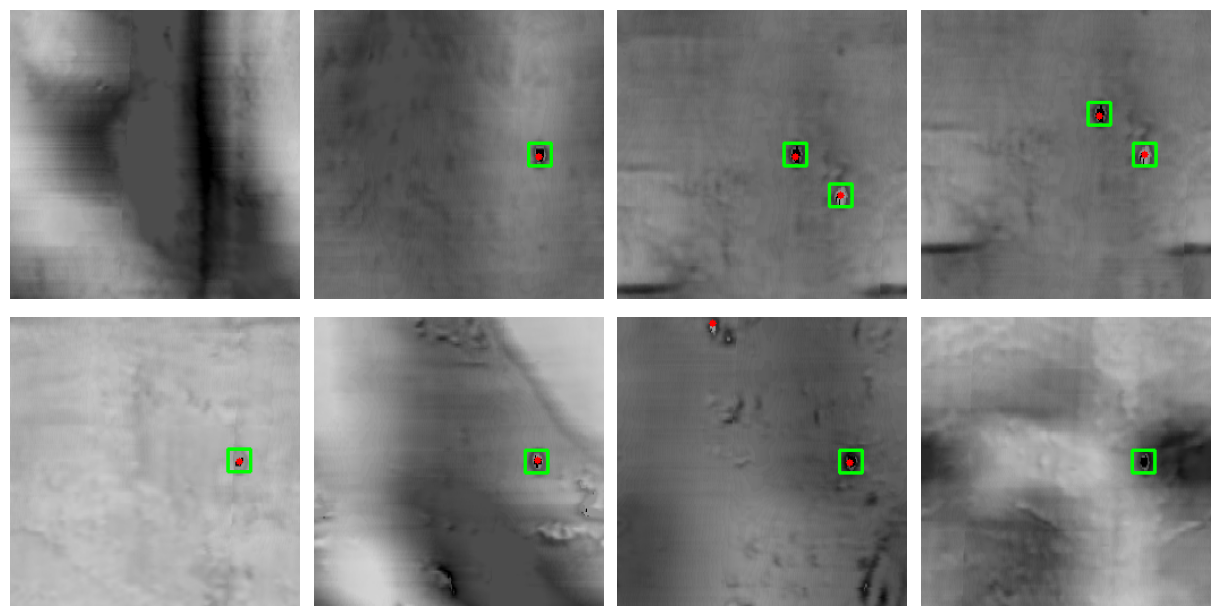

In [13]:
plot_images(train_detecor.all_transforms["input"], pred_centroids=train_predictions, true_centroids=train_masks_centroids, n=4*2)

### Results on the test dataset

In [14]:
test_detecor = CoringDetector(metric="f1_score", N1=23, N2=7, N3=5, canny_sigma=2.6, max_area=400, max_round_ratio=1.0, min_area=0.5, min_round_ratio=0.5)
test_predictions = test_detecor.fit_transform(test_dataset)
test_detecor.score(test_dataset, test_masks_centroids)

print("TP", test_detecor.true_positives_rate)
print("FP", test_detecor.false_positives_rate)
print("FN", test_detecor.false_negatives_rate)
print("Recall", test_detecor.recall)
print("Precision", test_detecor.precision)
print("f1_score", test_detecor.f1_score)

TP 0.596958174904943
FP 0.4790874524714829
FN 0.40304182509505704
Recall 0.596958174904943
Precision 0.5547703180212014
f1_score 0.5750915750915752


Quadrados verdes indicam regiões verdadeiras, e pontos vermelhos indicam regiões preditas pelo modelo.

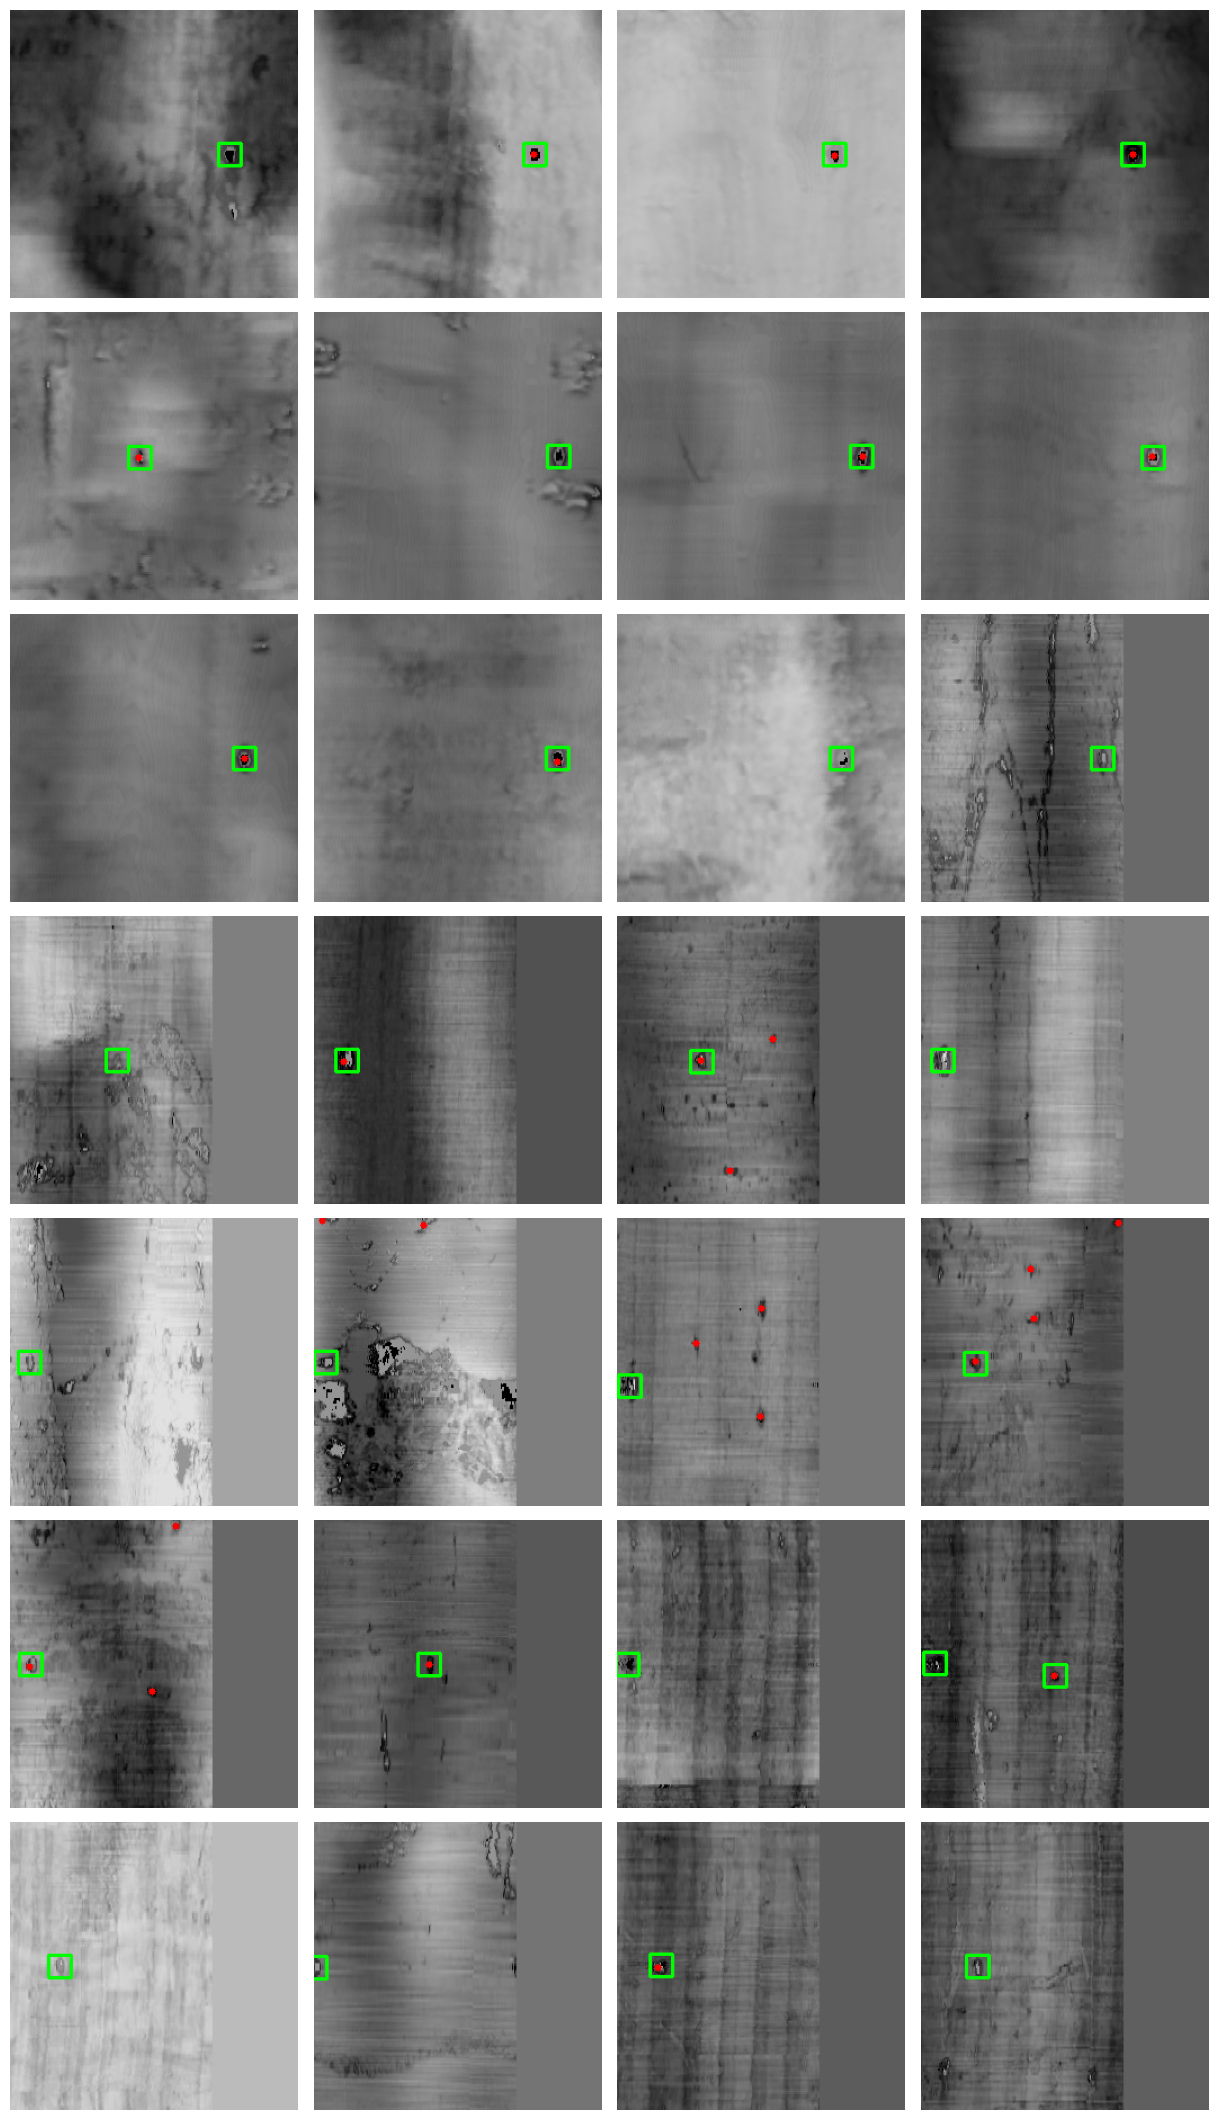

In [33]:
plot_images(test_detecor.all_transforms["input"], pred_centroids=test_predictions, true_centroids=test_masks_centroids, n=4*7)

## Pipeline

In [16]:
len(train_detecor.contours[2])

2

input


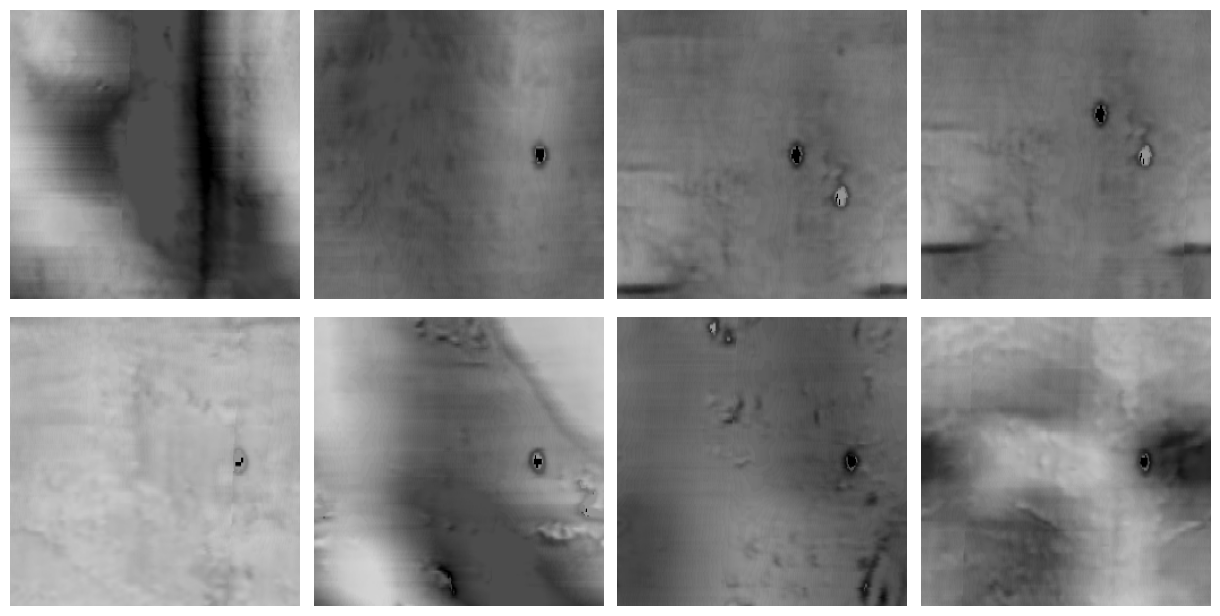

canny


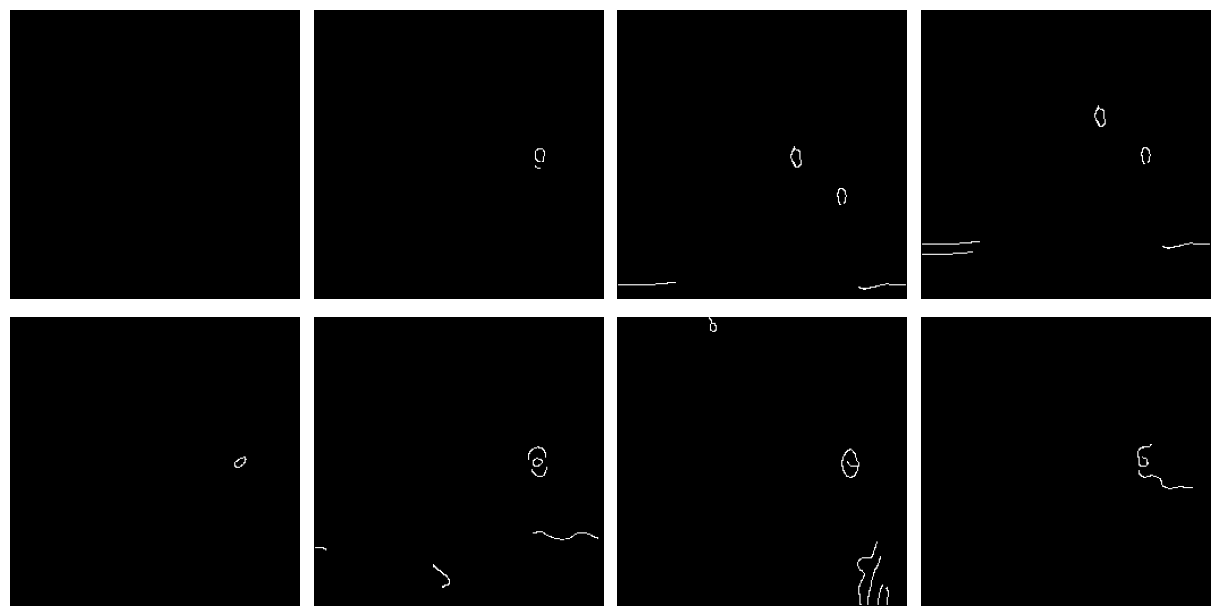

closing


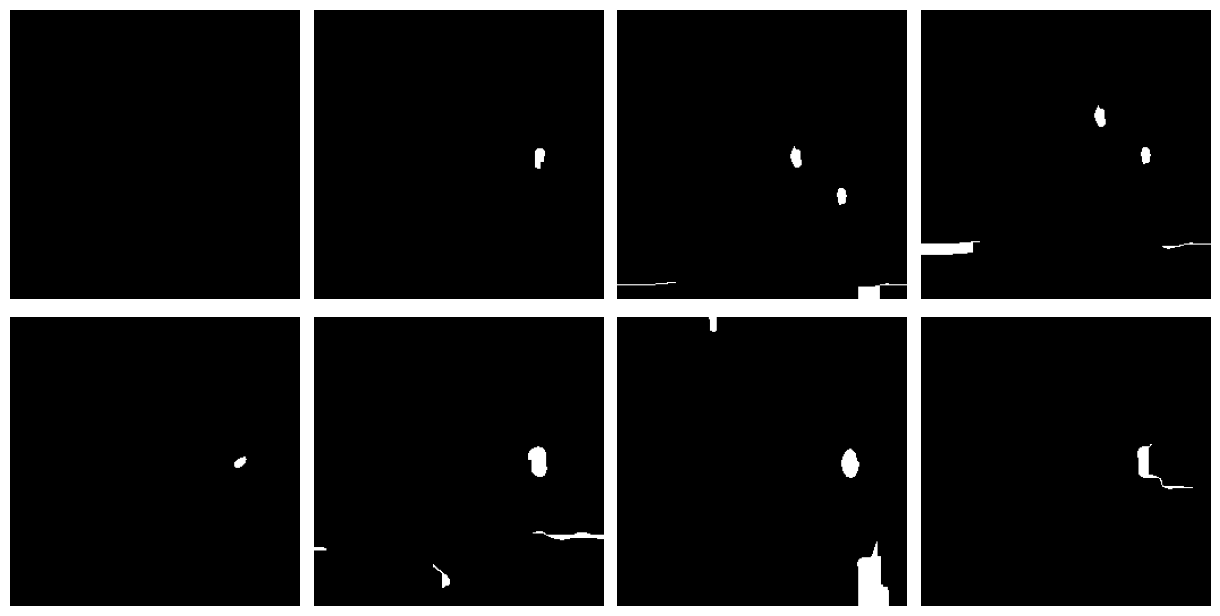

filtered outputs


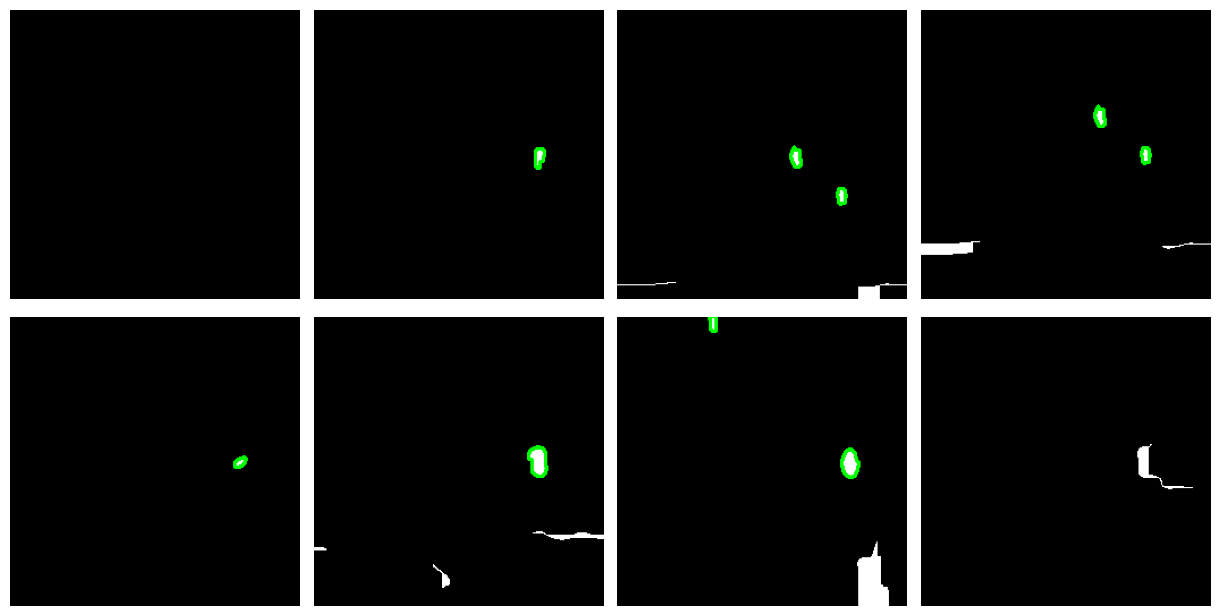

centroids


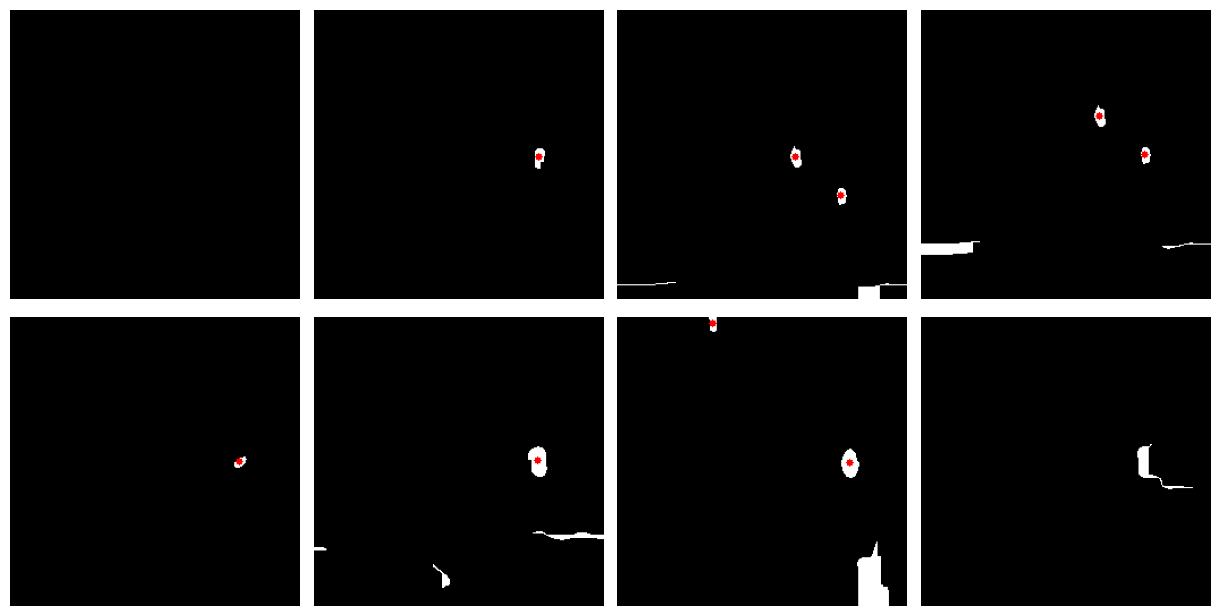

Scores


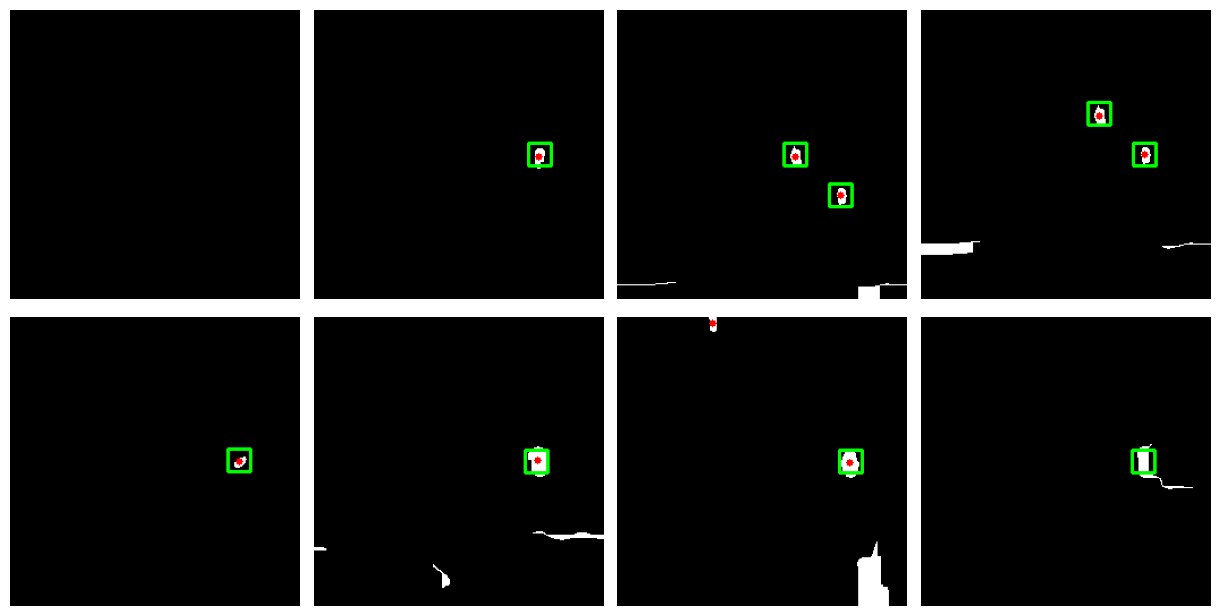

In [27]:
for i in train_detecor.all_transforms:
    print(i)
    plot_images(train_detecor.all_transforms[i], n=4*2)

print('filtered outputs')
plot_images(train_detecor.all_transforms['closing'], contours_list=train_detecor.contours, n=4*2)

print('centroids')
plot_images(train_detecor.all_transforms["closing"], pred_centroids=train_predictions, n=4*2)

print("Scores")
plot_images(train_detecor.all_transforms["closing"], pred_centroids=train_predictions, true_centroids=train_masks_centroids, n=4*2)

### Features statistics

In [18]:
plt.style.use('ggplot')

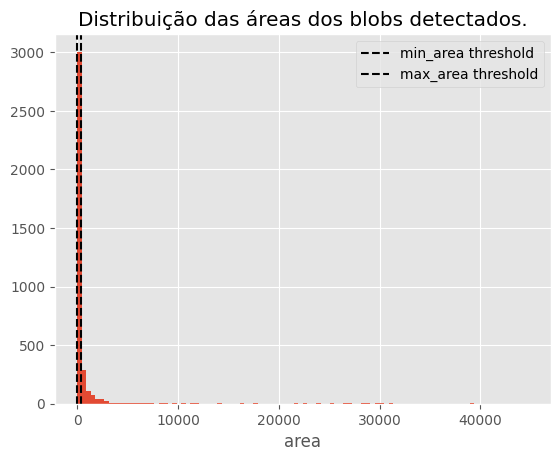

In [19]:
roudness = train_detecor.roundness
area = train_detecor.contour_areas

plt.hist(area, bins=100)
plt.axvline(x=0.5, color='black', linestyle='--', label='min_area threshold')
plt.axvline(x=400, color='black', linestyle='--', label='max_area threshold')
plt.xlabel('area')
# plt.xlim(0, 1000)
plt.title("Distribuição das áreas dos blobs detectados.")
plt.legend()
plt.show()

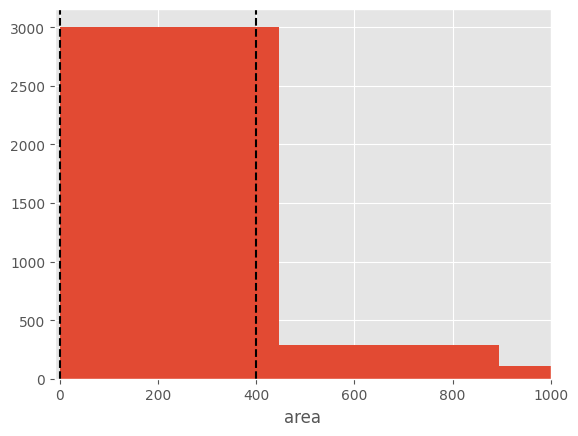

In [20]:
plt.hist(area, bins=100)
plt.axvline(x=0.5, color='black', linestyle='--', label='min_area threshold')
plt.axvline(x=400, color='black', linestyle='--', label='max_area threshold')
plt.xlabel('area')
plt.xlim(-10, 1000)
# plt.title("Distribuição das áreas dos blobs detectados.")
# plt.legend()
plt.show()

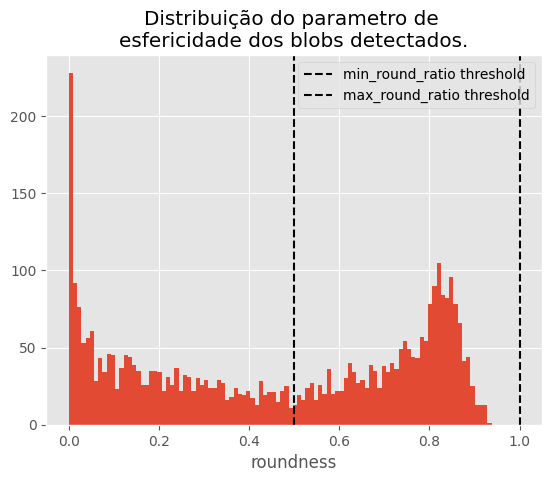

In [21]:


plt.hist(roudness, bins=100)
plt.axvline(x=0.5, color='black', linestyle='--', label='min_round_ratio threshold')
plt.axvline(x=1.0, color='black', linestyle='--', label='max_round_ratio threshold')
plt.xlabel('roundness')
plt.title("Distribuição do parametro de \nesfericidade dos blobs detectados.")
plt.legend()
plt.show()